## АНАЛИЗ ЭФФЕКТИВНОСТИ ДВУХ ВАРИАНТОВ ПОСАДОЧНОЙ СТРАНИЦЫ

Представьте, что вы — Data Scientist в туристической фирме. Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта и провела A/B-тестирование. В результате эксперимента были собраны данные — скачайте их по ссылке ниже.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest, proportions_chisquare,\
    proportion_confint
from scipy.stats import shapiro, ttest_ind, norm, t


Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.zip')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Наша таблица представлена следующими полями:

user_id — идентификатор пользователя, зашедшего на сайт;  
data — дата посещения сайта;  
group — группа теста (контрольная — А или тестовая — B);  
purchase — признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет);   
price — цена купленного тура (если покупка не состоялась, цена равна 0).  

## Часть 1 Проанализируйте структуру данных и проведите их предобработку:

### исследуйте структуру данных;

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


### преобразуйте столбцы к необходимым типам данных.

In [4]:
data['date'] = pd.to_datetime(data['date'], yearfirst=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   294478 non-null  int64         
 1   date      294478 non-null  datetime64[ns]
 2   group     294478 non-null  object        
 3   purchase  294478 non-null  int64         
 4   price     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 11.2+ MB


### Убедитесь в одинаковой длительности проведения A/B-тестирования в каждой из групп. Если длительность разная, унифицируйте данные, удалив лишние данные для соответствующей группы.

In [6]:
print(sorted(data[data['group'] == 'A'].date.unique()) == sorted(data[data['group'] == 'B'].date.unique()))

True


**Вывод:** Длительности проведения A/B-тестирования в каждой из групп одинакова.

### Проверьте данные на наличие пропусков и избавьтесь от них, если нужно.

In [7]:
print(f'Количество пропусков: {data.isna().sum().sum()}')

Количество пропусков: 0


### Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе группы. Если да, исключите пользователей, оказавшихся в обеих группах.

In [8]:
user_to_remove = set(data[data['group'] == 'A'].user_id.unique()).intersection(set(data[data['group'] == 'B'].user_id.unique()))

print(f'Количество пользователей, участвующих в обоих группах: {len(user_to_remove)}')

Количество пользователей, участвующих в обоих группах: 1895


In [9]:
index_to_drop = data[data['user_id'].isin(user_to_remove)].index

data = data.drop(index=index_to_drop, axis=1)

In [10]:
user_to_remove = set(data[data['group'] == 'A'].user_id.unique()).intersection(set(data[data['group'] == 'B'].user_id.unique()))

print(f'Количество пользователей, участвующих в обоих группах: {len(user_to_remove)}')

Количество пользователей, участвующих в обоих группах: 0


## Часть 2 Сделайте первичный анализ результатов A/B-тестирования:

### Рассчитайте вспомогательные показатели для контрольной и тестовой групп:

### - количество посещений сайта; 
### - суммарное количество совершённых покупок; 
### - сумма всех покупок.

In [11]:
site_entring_a = data[data['group'] == 'A'].shape[0]
site_entring_b = data[data['group'] == 'B'].shape[0]
print(f'Количество посещения сайта для групп А и B: {site_entring_a}, {site_entring_b}')

purchase_a = data[(data['group'] == 'A') & (data['price'] != 0)].shape[0]
purchase_b = data[(data['group'] == 'B') & (data['price'] != 0)].shape[0]
print(f'Количество совершенных покупок для групп А и B: {purchase_a}, {purchase_b}')

purchase_sum_a = data[data['group'] == 'A'].price.sum()
purchase_sum_b = data[data['group'] == 'B'].price.sum()
print(f'Сумма всех покупок для групп А и B: {purchase_sum_a}, {purchase_sum_b}')

Количество посещения сайта для групп А и B: 145307, 145381
Количество совершенных покупок для групп А и B: 17487, 17290
Сумма всех покупок для групп А и B: 1417780000, 1533010000


**Вывод:** Количество посещений обоих версий сайта практически одинаково. Для выборки А нескольбольше количество совершенных покупок, для выборки В нескольок больше сумма всех покупок. С уверенностью можно сказать, что выборки сбалансированны.

### В каждой из групп рассчитайте ключевые показатели:

### - конверсия;
### - средний чек.
### Сделайте первичные выводы о результатах A/B-тестирования на основе показателей конверсии и среднего чека в каждой из групп. По какому(-им) показателю(-ям), на первый взгляд, вариант А эффективнее варианта B и наоборот?

In [12]:
conversion_a = purchase_a / site_entring_a * 100
conversion_b = purchase_b / site_entring_b * 100
print(f'Конверсия для групп А и B: {round(conversion_a, 2)}, {round(conversion_b, 2)}')

mean_reciept_a = data[(data['group'] == 'A') & (data['price'] != 0)].price.mean()
mean_reciept_b = data[(data['group'] == 'B') & (data['price'] != 0)].price.mean()
print(f'Средний чек для групп А и B: {round(mean_reciept_a, 2)}, {round(mean_reciept_b, 2)}')

Конверсия для групп А и B: 12.03, 11.89
Средний чек для групп А и B: 81076.23, 88664.55


**Вывод:** Все еще нельзя с уверенностью сказать, какая группа имеет лучшие показатели. По конверсии результаты немного лучше у группы А, по среднему чеку у группы В. 

### Сравните варианты A/B по покупательской способности каждого из туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. Визуализируйте полученную сводную таблицу.

### Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем покупательская способность участников группы B, и наоборот?

In [13]:
purchasing_power = data[data['price'] != 0][['group', 'price', 'purchase']].groupby(['group', 'price'], as_index=False).count().\
    rename(columns={'purchase': 'count'})
    
purchasing_power.head()

,group,price,count
0,A,10000,5182
1,A,60000,5271
2,A,100000,1832
3,A,150000,3478
4,A,200000,1724


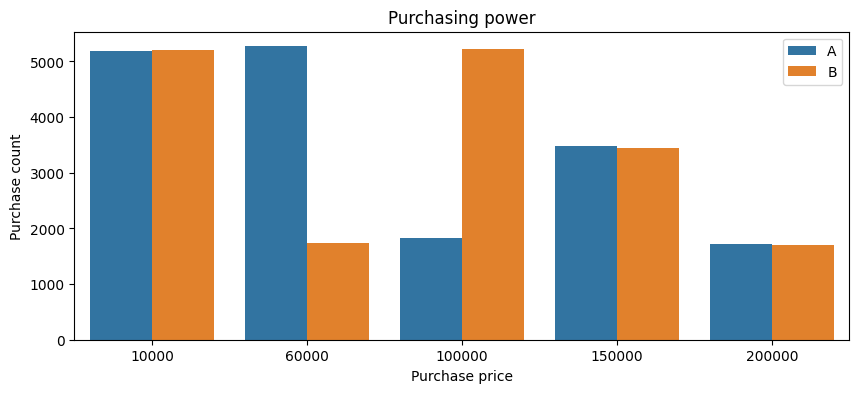

In [14]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость

#Строим линейный график зависимости precision от threshold
sns.barplot(data=purchasing_power, x='price', y='count', hue='group', ax=ax) 

#Даем графику название и подписи осям
ax.set_title('Purchasing power')
ax.set_xlabel('Purchase price')
ax.set_ylabel('Purchase count')
ax.legend();

**Вывод:** По заказам на сумму в 60 000 группа А значительно опережает группу В. Однако, по заказам на сумму 100 000 группа В значительно опережает группу А. Для заказов на другие суммы количество заказов примерно одинаково. Из полученных данных нет возможности установить какая группа имеет лучшие показатели.

## Часть 3 Проанализируйте данные на предмет стабилизации метрик:

### Сгруппируйте данные по дате и группе тестирования и постройте таблицу с ежедневными данными результатов проведения A/B-тестирования. В каждой группе вычислите ежедневные показатели:

### - количество посещений страницы;
### - количество покупок;
### - сумму покупок.

In [15]:
daily_data = data.groupby(['date', 'group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={'user_id': 'enter_count', 
                                 'purchase': 'purchase_count', 
                                 'price': 'reciept_sum'})

daily_data.head()

,date,group,enter_count,purchase_count,reciept_sum
0,2021-01-02,A,2854,359,29410000
1,2021-01-02,B,2861,345,29660000
2,2021-01-03,A,6596,748,62000000
3,2021-01-03,B,6619,754,65960000
4,2021-01-04,A,6566,799,64250000


### Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и о ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок).

In [16]:
daily_data['conversion'] = daily_data['purchase_count'] / daily_data['enter_count'] * 100
daily_data['mean_reciept'] = daily_data['reciept_sum'] / daily_data['enter_count']

daily_data.head()

,date,group,enter_count,purchase_count,reciept_sum,conversion,mean_reciept
0,2021-01-02,A,2854,359,29410000,12.578837,10304.835319
1,2021-01-02,B,2861,345,29660000,12.058721,10367.004544
2,2021-01-03,A,6596,748,62000000,11.340206,9399.636143
3,2021-01-03,B,6619,754,65960000,11.391449,9965.251549
4,2021-01-04,A,6566,799,64250000,12.168748,9785.257387


### Рассчитайте кумулятивные показатели:

### - кумулятивное количество посещений страницы;
### - кумулятивное количество покупок;
### - кумулятивную сумму покупок.

In [17]:
daily_data['cum_enter_count'] = daily_data.groupby('group')['enter_count'].cumsum()
daily_data['cum_purchase_count'] = daily_data.groupby('group')['purchase_count'].cumsum()
daily_data['cum_reciept_sum'] = daily_data.groupby('group')['reciept_sum'].cumsum()

daily_data.head()

,date,group,enter_count,purchase_count,reciept_sum,conversion,mean_reciept,cum_enter_count,cum_purchase_count,cum_reciept_sum
0,2021-01-02,A,2854,359,29410000,12.578837,10304.835319,2854,359,29410000
1,2021-01-02,B,2861,345,29660000,12.058721,10367.004544,2861,345,29660000
2,2021-01-03,A,6596,748,62000000,11.340206,9399.636143,9450,1107,91410000
3,2021-01-03,B,6619,754,65960000,11.391449,9965.251549,9480,1099,95620000
4,2021-01-04,A,6566,799,64250000,12.168748,9785.257387,16016,1906,155660000


### На основе полученных кумулятивных показателей вычислите кумулятивную конверсию и кумулятивный средний чек.

In [18]:
daily_data['cum_conversion'] = daily_data['cum_purchase_count'] / daily_data['cum_enter_count'] * 100
daily_data['cum_mean_reciept'] = daily_data['cum_reciept_sum'] / daily_data['cum_enter_count']

daily_data.head()

,date,group,enter_count,purchase_count,reciept_sum,conversion,mean_reciept,cum_enter_count,cum_purchase_count,cum_reciept_sum,cum_conversion,cum_mean_reciept
0,2021-01-02,A,2854,359,29410000,12.578837,10304.835319,2854,359,29410000,12.578837,10304.835319
1,2021-01-02,B,2861,345,29660000,12.058721,10367.004544,2861,345,29660000,12.058721,10367.004544
2,2021-01-03,A,6596,748,62000000,11.340206,9399.636143,9450,1107,91410000,11.714286,9673.015873
3,2021-01-03,B,6619,754,65960000,11.391449,9965.251549,9480,1099,95620000,11.592827,10086.497890
4,2021-01-04,A,6566,799,64250000,12.168748,9785.257387,16016,1906,155660000,11.900599,9719.030969


### Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням.

### Сделайте выводы. Можно ли назвать A/B-тест завершённым? Стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

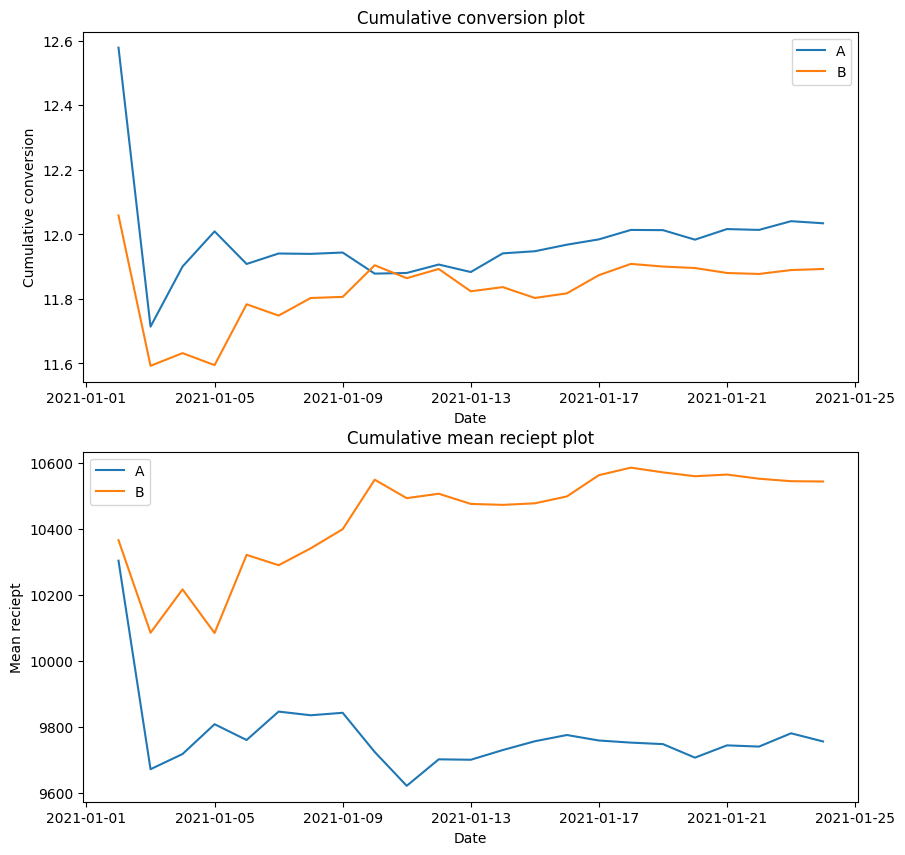

In [19]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 10), nrows=2) #фигура + координатная плоскость

#Строим линейный график зависимости precision от threshold
sns.lineplot(data=daily_data, x='date', y='cum_conversion', hue='group', ax=ax[0]) 
#Даем графику название и подписи осям
ax[0].set_title('Cumulative conversion plot')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Cumulative conversion')
ax[0].legend()

sns.lineplot(data=daily_data, x='date', y='cum_mean_reciept', hue='group', ax=ax[1]) 
ax[1].set_title('Cumulative mean reciept plot')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Mean reciept')
ax[1].legend();

**Вывод:** Графики комулятивной конверсии и среднего дневного чека стабилизировались. И з этого можем сделать вывод, что в настоящее время имеется достаточно данных для проведения А/В тестирования.  
Исходя из графиков можно предположить, что конверсия выше у группы А, а средний чек у группы В.

## Часть 4 Проведите статистический анализ результатов A/B-тестирования:

### Сформулируйте статистические гипотезы, соответствующие поставленным бизнес-вопросам, и выберите статистический тест для их проверки.

### Не забудьте проверить данные на нормальность там, где это необходимо.

**Гипотеза 1:** Конверсия выше у группы А.

**Гипотеза 2:** Средний чек больше у группы В.

Для проверки гипотезы 1 будем использовать либо Z-тест либо Хи квадрат. Так как у нас большое количество наблюдений, тесты должны дать один итот же результат. Вот и проверим. Попробуем использовать оба варианта теста.

Для проверки гипотезы 2 будем использовать либо t-тест либо тест по критерию Мана-Уитни. Для определения применимости тестов данные предварительно необходимо проверить на нормальное распределение.

Сразу зададим уровень значимости 0.05

In [20]:
alpha = 0.05

### С помощью аппарата статистических тестов определите:

### - Есть ли статистическая разница между конверсиями в группах А и B?
### - Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

### Гипотеза 1

In [21]:
converted = data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)

display(converted)

,sum,count
group,,
A,17487,145307
B,17290,145381


Испробуем правосторонняя Z-тест.  
Нулевая гипотеза: Конверсия А меньше или равно В
Альтернативная гипотеза: Конверсия А больше В

In [22]:
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted['sum'], #число «успехов»
    nobs=converted['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.12
У нас нет оснований отвергнуть нулевую гипотезу


Испробуем правосторонний тест Хи квадрат.  
Нулевая гипотеза: Конверсия А равна В
Альтернативная гипотеза: Конверсия А не равна В

In [23]:
# вычисляем значение p-value для Z-теста для пропорций
_, p_value, c = proportions_chisquare(
    count=converted['sum'], #число «успехов»
    nobs=converted['count'], #общее число наблюдений
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.239
У нас нет оснований отвергнуть нулевую гипотезу


**Вывод:** У нас нет основания предполагать, что конверсия группы А отличается от конверсии группы В.

### Гипотеза 2

In [24]:
daily_reciept = daily_data.pivot(index='date', columns='group')['mean_reciept']
daily_reciept.head()

group,A,B
date,,
2021-01-02,10304.835319,10367.004544
2021-01-03,9399.636143,9965.251549
2021-01-04,9785.257387,10408.506732
2021-01-05,10034.198663,9760.405468
2021-01-06,9598.849531,11112.427788


Проверим данные на нормальное распределение. Сначала визуально.

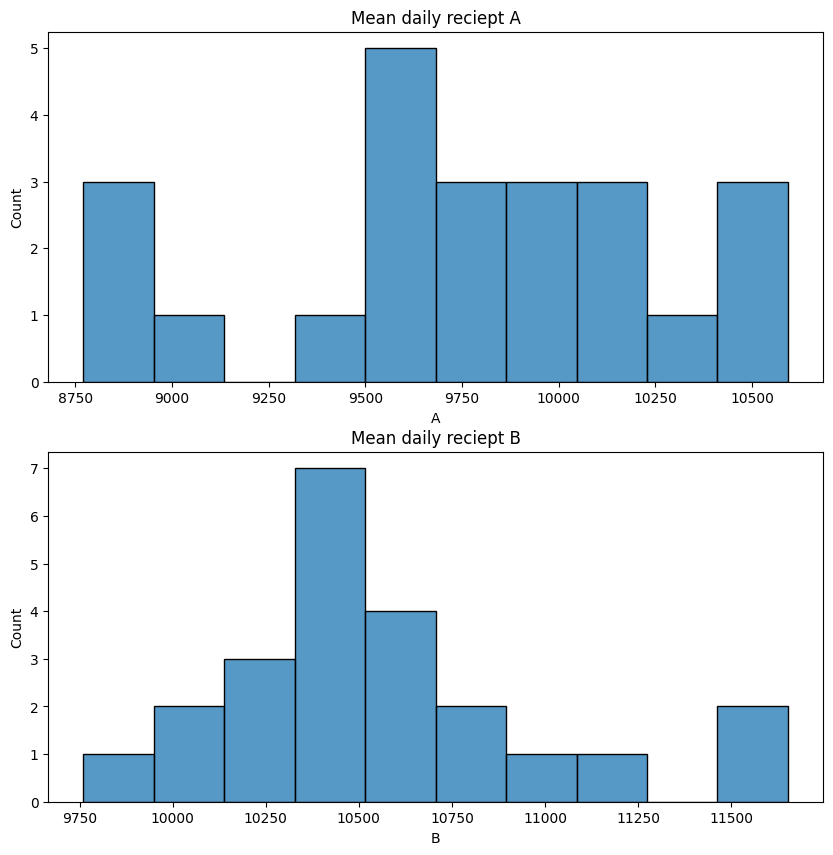

In [25]:
fig, ax = plt.subplots(figsize=(10, 10), nrows=2) #фигура + координатная плоскость

#Строим линейный график зависимости precision от threshold
sns.histplot(data=daily_reciept['A'], ax=ax[0], bins=10) 
#Даем графику название и подписи осям
ax[0].set_title('Mean daily reciept A')

sns.histplot(data=daily_reciept['B'], ax=ax[1], bins=10) 
ax[1].set_title('Mean daily reciept B');

Затем тестом Шапиро-Уилка.

In [26]:
# вычисляем результат теста Шапиро — Уилка для выборок
shapiro_result_a = shapiro(daily_reciept['A'])
shapiro_result_b = shapiro(daily_reciept['B'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value для группы А с уровнем значимости
if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

# сравниваем полученное p-value для группы B с уровнем значимости
if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе B является нормальным")

p-value группы А 0.22
p-value группы B 0.2
Принимаем нулевую гипотезу. Распределение в группе А является нормальным
Принимаем нулевую гипотезу. Распределение в группе B является нормальным


Так как распределение является нормальным применяем левосторонний t-тест.    
Нулевая гипотеза: Средний чек А больше или равен В  
Альтернативная гипотеза: Средний чек В больше А

In [27]:
results = ttest_ind(
    a=daily_reciept['A'],
    b=daily_reciept['B'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


**Вывод:** После проведения теста можем обоснованно заявить, что средний дневной чек группы В больше чем у группы А.

### Подкрепите результаты статистических тестов, построив 95 % доверительные интервалы для:

### - конверсий в каждой из групп;
### - разницы конверсий в группах;
### - ежедневного среднего чека в каждой из групп.

In [28]:
gamma = 0.95

In [29]:
# вычисляем доверительный интервал для конверсии в группе A с уровнем доверия 0.95
lower_bound_a, upper_bound_a = proportion_confint(
    count=converted['sum']['A'],
    nobs=converted['count']['A'],
    alpha=0.05
)

# вычисляем доверительный интервал для конверсии в группе B с уровнем доверия 0.95
lower_bound_b, upper_bound_b = proportion_confint(
    count=converted['sum']['B'],
    nobs=converted['count']['B'],
    alpha=0.05
)
# выводим результат
print('Доверительный интервал для конверсии в группе А: {}'.format((round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
print('Доверительный интервал для конверсии в группе B: {}'.format((round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))

Доверительный интервал для конверсии в группе А: (11.87, 12.2)
Доверительный интервал для конверсии в группе B: (11.73, 12.06)


In [30]:
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z-критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound

In [31]:
# размеры выборок групп А и B
n = [data[data['group'] == 'A'].shape[0], data[data['group'] == 'B'].shape[0]]
# выборочная пропорция групп A и B
x_p = [data[data['group'] == 'A'].purchase.mean(), data[data['group'] == 'B'].purchase.mean()]


# строим доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)


# выводим результат
print('Доверительный интервал для разности конверсий: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


In [32]:
scale_a = daily_data[daily_data['group'] == 'A'].mean_reciept.std()/(daily_data[daily_data['group'] == 'A'].shape[0] ** 0.5)
scale_b = daily_data[daily_data['group'] == 'B'].mean_reciept.std()/(daily_data[daily_data['group'] == 'B'].shape[0] ** 0.5)

lower_a, upper_a = t.interval(confidence=gamma, df=daily_data[daily_data['group'] == 'A'].shape[0],\
    loc=daily_data[daily_data['group'] == 'A'].mean_reciept.mean(), scale=scale_a)
lower_b, upper_b = t.interval(confidence=gamma, df=daily_data[daily_data['group'] == 'B'].shape[0],\
    loc=daily_data[daily_data['group'] == 'B'].mean_reciept.mean(), scale=scale_b)

print('Доверительный интервал для среднего дневного чека группы А: {}'.format((round(lower_a), round(upper_a))))
print('Доверительный интервал для среднего дневного чека группы В: {}'.format((round(lower_b), round(upper_b))))

Доверительный интервал для среднего дневного чека группы А: (9528, 9979)
Доверительный интервал для среднего дневного чека группы В: (10343, 10734)


### Проинтерпретируйте построенные доверительные интервалы для конверсий и ежедневного среднего чека в группах. Есть ли перекрытие между доверительными интервалами для групп? Если есть, то о чём это говорит?

**Вывод:** Доверительные интервалы для конверсии группы А и В пересекаются, а доверительный интервал для разницы конверсий в группах А и В охватывает ноль. Из этого можно сделать вывод, что построеные доверительные интервалы подтверждают результаты проверки тестами гипотезы 1. То есть нет статистически значивой разницы в конверсии для групп А и В.  

Доверительный интервал для среднего дневного чека группы В расположен правее по координатной прямой чем доверительный интервал группы А. Можно сделать вывод, что результаты статистических тестов для среднего дневного чека так же подтверждаются построенными доверительными интервалами. Средний дневной чек в группе В больше среднего дневного чека в группе А. 

## Часть 5 Сделайте общий вывод по результатам A/B-теста.

### Какой варианта дизайна посадочной страницы более эффективен по метрикам конверсии и ежедневного среднего чека и почему?

**Вывод:** Результаты проведенных статистических тестов были подтверждены построением доверительных интервалов. В результате имеем:  
**Гипотеза 1:** Конверсия выше у группы А. - ***Не подтверждена***  
**Гипотеза 2:** Средний чек больше у группы В. - ***Подтверждена***  

Исходя из того, что нет статистически значимой разницы в конверсиях для двух групп и, что средний дневной чек выше для группы В, можем рекомендовать применения сайта, который тестироваляся с группой В.